<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
%pylab inline
%matplotlib inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, Input, Flatten, Embedding, multiply, SpatialDropout1D, BatchNormalization, Dropout
from tensorflow.keras.models import Model, save_model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями
from tensorflow.keras.preprocessing.text import Tokenizer  # импортируем токенизатор
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # колбэки
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score# Для разделения выборки на тестовую и обучающую
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import spacy
import nltk
from textblob import TextBlob
from catboost import CatBoostClassifier
from catboost import cv, Pool

C:\ana\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\ana\lib\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [4]:
try:
    data = pd.read_csv('toxic_comments.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [5]:
data = data.drop('Unnamed: 0',axis = 1)

In [6]:
data

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


вывод eda: проблем с типом данных нет
<br>данные пропусков не имеет
<br>дубликаты отсутсвуют 
<br>обнаружены различные неинформативные значения в тексте 
<br>данные нуждаются в очистке 

## Обучение

In [8]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

виден дисбаланс класса , в идеале нужно его устранить или изменить порог класса хотя бы до 0.3

сделаем лематизацию

In [9]:
lemmatizer = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [10]:
def lemmatize(sentence):
    doc = lemmatizer(sentence)
    return " ".join([token.lemma_ for token in doc])

In [11]:
data['text'] = data['text'].apply(lemmatize)

In [12]:
all_text = data['text'].to_list()

In [13]:
max_words = 61000  # размер словаря
# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
# Использованы параметры:
# num_words   - объем словаря
# filters     - убираемые из текста ненужные символы
# lower       - приведение слов к нижнему регистру
# split       - разделитель слов
# char_level  - указание разделять по словам, а не по единичным символам
# oov_token   - токен для слов, которые не вошли в словарь

# Построение частотного словаря по текстам
tokenizer.fit_on_texts(all_text)

In [14]:
ans_text = tokenizer.texts_to_sequences(data['text'])

In [15]:
data['ans_text'] = ans_text
data

,text,toxic,ans_text
0,Explanation \n why the edit make under my user...,0,"[586, 80, 3, 39, 48, 191, 28, 631, 3783, 9570,..."
1,D'aww ! he match this background colour I be s...,0,"[1, 37, 1018, 17, 533, 2459, 5, 2, 3815, 934, ..."
2,"hey man , I be really not try to edit war . it...",0,"[390, 316, 5, 2, 143, 11, 120, 4, 39, 234, 12,..."
3,""" \n More \n I can not make any real suggestio...",0,"[64, 5, 31, 11, 48, 60, 323, 701, 18, 1334, 5,..."
4,"you , sir , be my hero . any chance you rememb...",0,"[8, 1523, 2, 28, 2482, 60, 911, 8, 539, 42, 24..."
...,...,...,...
159287,""" : : : : : and for the second time of asking ...",0,"[7, 16, 3, 382, 78, 6, 22609, 85, 21, 217, 553..."
159288,you should be ashamed of yourself \n\n that be...,0,"[8, 59, 2, 3935, 6, 213, 10, 2, 9, 2851, 123, ..."
159289,"Spitzer \n\n Umm , there s no actual article f...",0,"[26399, 6130, 43, 258, 50, 711, 20, 16, 6796, ..."
159290,and it look like it be actually you who put on...,0,"[7, 12, 100, 52, 12, 2, 218, 8, 69, 181, 18, 3..."


токенизация завершена 

In [16]:
# функция для подсчёта метрики F1
def compute_metric(pred, y):
    score = f1_score(y, pred)
    return score

In [17]:
#находим максимальную последовательность в ответах
len_vector = 0
for i in data['ans_text']:
    if len_vector <= len(i): len_vector=len(i)

print(len_vector)

1403


делим на трайн валид и тест

In [18]:
x_train = pad_sequences(ans_text)

In [19]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train, data['toxic'], test_size=0.15, shuffle=True)

In [20]:
x_tr, x_test, y_tr, y_test = train_test_split(x_tr, y_tr, test_size=0.15, shuffle=True)

In [21]:
x_tr

array([[   0,    0,    0, ..., 2081,   28,  305],
       [   0,    0,    0, ...,  424,    4,    8],
       [   0,    0,    0, ..., 3347, 2624, 3843],
       ...,
       [   0,    0,    0, ...,    9, 1581, 4451],
       [   0,    0,    0, ...,    8,  200,  668],
       [   0,    0,    0, ...,   20,   44,   17]])

In [22]:
#Создаём сеть с Embedding слоем
model03 = Sequential()
model03.add(Embedding(max_words, 20, input_length=len_vector, mask_zero=True))
model03.add(SpatialDropout1D(0.2))
model03.add(Flatten())
# model03.add(BatchNormalization())
model03.add(Dense(200, activation="relu"))
model03.add(Dense(1, activation='sigmoid'))

model03.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model03.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1403, 20)          1220000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 1403, 20)         0         
 ropout1D)                                                       
                                                                 
 flatten (Flatten)           (None, 28060)             0         
                                                                 
 dense (Dense)               (None, 200)               5612200   
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 6,832,401
Trainable params: 6,832,401
Non-trainable params: 0
______________________________________________

In [23]:
earlystop_callb = EarlyStopping(monitor='val_accuracy',   # колбэк на остановку
                                patience=3,
                                )

checkpoint_callb = ModelCheckpoint(filepath='хак2.h5',   # колбэк на сохранение лучшей модели
                                   monitor='val_accuracy',
                                   save_best_only=True)

reducelr_callb = ReduceLROnPlateau(monitor ='val_accuracy',    # колбэк на уменьшения lr
                                   factor=0.1,
                                   patience=20,
                                   verbose=1)

In [24]:
history = model03.fit(x_tr,
                      y_tr,
                      epochs=20,
                      batch_size=512,
                      validation_data=(x_val, y_val),
                      callbacks=[reducelr_callb,
                                                    checkpoint_callb,
                                                    earlystop_callb]
                      )

Epoch 1/20
225/225 [==============================] - 40s 175ms/step - loss: 0.2378 - accuracy: 0.9194 - val_loss: 0.1485 - val_accuracy: 0.9474 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - 39s 175ms/step - loss: 0.1191 - accuracy: 0.9572 - val_loss: 0.1272 - val_accuracy: 0.9554 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - 38s 169ms/step - loss: 0.0838 - accuracy: 0.9698 - val_loss: 0.1277 - val_accuracy: 0.9578 - lr: 0.0010
Epoch 4/20
225/225 [==============================] - 37s 164ms/step - loss: 0.0600 - accuracy: 0.9788 - val_loss: 0.1430 - val_accuracy: 0.9592 - lr: 0.0010
Epoch 5/20
225/225 [==============================] - 37s 163ms/step - loss: 0.0430 - accuracy: 0.9849 - val_loss: 0.1598 - val_accuracy: 0.9574 - lr: 0.0010
Epoch 6/20
225/225 [==============================] - 37s 164ms/step - loss: 0.0302 - accuracy: 0.9900 - val_loss: 0.1785 - val_accuracy: 0.9557 - lr: 0.0010
Epoch 7/20
225/225 [==============================] 

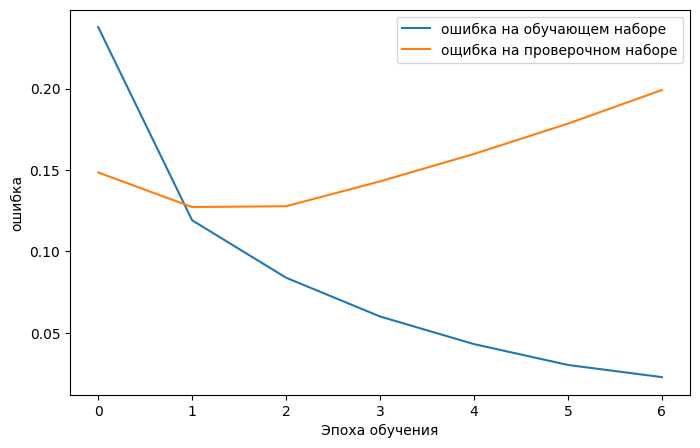

In [25]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'],
         label='ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='ощибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('ошибка')
plt.legend()
plt.show()

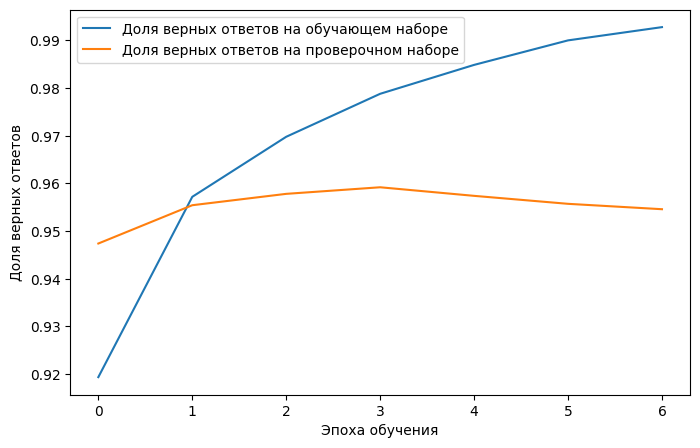

In [26]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend() 
plt.show()

In [27]:
model03 = load_model('хак2.h5')

In [28]:
pre = model03.predict(x_val)

747/747 [==============================] - 4s 5ms/step


In [29]:
li_pre = [int(round(i[0], 0)) for i in pre] 

In [30]:
compute_metric(li_pre, y_val) 

0.7781569965870307

0.77 на валидации не плохо , а теперь попробуем catboost

но для начало стоп слова

In [31]:
nltk.download("stopwords")
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Алексей\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


для того чтобы загрузить в catboost данные нужно не много по другому векторизировать

In [32]:
vectorizer = TfidfVectorizer(stop_words=stop_words)

In [33]:
x_tr = vectorizer.fit_transform(data['text'])
y_tr = data['toxic']

In [34]:
cb_params = {
             'eval_metric': 'F1',
             'loss_function' : 'Logloss',
             'learning_rate': 0.6,
             'iterations' : 1000,
             'random_seed': 42,
             'verbose':100}

train_data = Pool(data=x_tr,
                  label=y_tr
                  )

In [35]:
%%time
cv_data = cv(
    params = cb_params,
    pool = train_data,
    fold_count=3,
    partition_random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)

Training on fold [0/3]
0:	learn: 0.3864821	test: 0.3911494	best: 0.3911494 (0)	total: 1.23s	remaining: 20m 28s
100:	learn: 0.7894373	test: 0.7419808	best: 0.7426042 (95)	total: 1m 18s	remaining: 11m 41s
200:	learn: 0.8357503	test: 0.7541434	best: 0.7541434 (200)	total: 2m 32s	remaining: 10m 5s

bestTest = 0.7541433548
bestIteration = 200

Training on fold [1/3]
0:	learn: 0.4235141	test: 0.4277457	best: 0.4277457 (0)	total: 798ms	remaining: 13m 17s
100:	learn: 0.7927880	test: 0.7496491	best: 0.7496491 (100)	total: 1m 14s	remaining: 11m
200:	learn: 0.8368823	test: 0.7559656	best: 0.7565734 (192)	total: 2m 25s	remaining: 9m 40s
300:	learn: 0.8465976	test: 0.7591966	best: 0.7593492 (289)	total: 3m 38s	remaining: 8m 26s
400:	learn: 0.8537988	test: 0.7604057	best: 0.7604860 (398)	total: 4m 49s	remaining: 7m 13s
500:	learn: 0.8602729	test: 0.7637397	best: 0.7642602 (493)	total: 6m 2s	remaining: 6m

bestTest = 0.7642601558
bestIteration = 493

Training on fold [2/3]
0:	learn: 0.4692238	test: 0

In [36]:
cv_data[cv_data['test-F1-mean'] == cv_data['test-F1-mean'].max()]

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
493,493,0.760024,0.005855,0.848132,0.010492,0.127975,0.001989,0.077123,0.010483
494,494,0.760024,0.005855,0.848074,0.010392,0.127978,0.001987,0.077107,0.010509
495,495,0.760024,0.005855,0.848055,0.010358,0.127981,0.001983,0.077092,0.010536
496,496,0.760024,0.005855,0.848055,0.010358,0.127986,0.001979,0.077077,0.010561


In [37]:
cb_score = cv_data['test-F1-mean'].max()
cb_score

0.7600240556748461

0.76 на валидации , устраивает давайте тестить

In [38]:
pre = model03.predict(x_test)
li_pre = [int(round(i[0], 0)) for i in pre] 
compute_metric(li_pre, y_test) 

635/635 [==============================] - 3s 5ms/step


0.7683881064162753

отлично порог пройден

## Выводы

<b>вывод:</b>
<br>по результату работы с данными . Тексты были очищенны и токенизированы.
<br>итог эксперементов с моделями:после проб с разными архитееткрами была выбрана лучшая и 
<br>рекомендации бизнесу: проблем нет 